In [2]:
import pandas as pd
import numpy as np
import MAIN.Basics as basics
import MAIN.Reinforcement as RL
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from UTIL import FileIO
from STRATEGY.Cointegration import EGCointegration
import time
import warnings
warnings.filterwarnings('ignore')



ModuleNotFoundError: No module named 'yaml'

In [104]:
# Read config
config_path  = 'CONFIG/config_train.yml'
config_train = FileIO.read_yaml(config_path)

# Read prices
x = pd.read_csv('STATICS/PRICE/JNJ.csv')
y = pd.read_csv('STATICS/PRICE/PG.csv')
x, y = EGCointegration.clean_data(x, y, 'date', 'close')
n_hist

[60, 120, 180, 240, 300, 360, 420, 480, 540, 600]

In [6]:
n_forward

NameError: name 'n_forward' is not defined

In [5]:
print('a')

a


Counter [Iteration]: 1000 steps processed...
Counter [Iteration]: 2000 steps processed...
Counter [Iteration]: 3000 steps processed...
Counter [Iteration]: 4000 steps processed...
Counter [Iteration]: 5000 steps processed...
Counter [Iteration]: 6000 steps processed...
Counter [Iteration]: 7000 steps processed...
Counter [Iteration]: 8000 steps processed...
Counter [Iteration]: 9000 steps processed...
Counter [Iteration]: 10000 steps processed...
Counter [Iteration]: 11000 steps processed...
Counter [Iteration]: 12000 steps processed...
Counter [Iteration]: 13000 steps processed...
Counter [Iteration]: 14000 steps processed...
Counter [Iteration]: 15000 steps processed...
Counter [Iteration]: 16000 steps processed...
Counter [Iteration]: 17000 steps processed...
Counter [Iteration]: 18000 steps processed...
Counter [Iteration]: 19000 steps processed...
Counter [Iteration]: 20000 steps processed...
Counter [Iteration]: Process completed.
Counter [Epoch]: 1 steps processed...
Counter [It

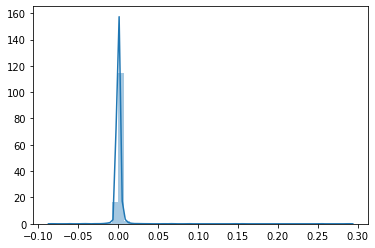

In [72]:
start = time.time()

# Separate training and testing sets
train_pct = 0.7
train_len = round(len(x) * 0.7)
idx_train = list(range(0, train_len))
idx_test  = list(range(train_len, len(x)))
EG_Train = EGCointegration(x.iloc[idx_train, :], y.iloc[idx_train, :], 'date', 'close')
EG_Test  = EGCointegration(x.iloc[idx_test,  :], y.iloc[idx_test,  :], 'date', 'close')

# Create action space
n_hist    = list(np.arange(60, 601, 60))
n_forward = list(np.arange(120, 1201, 120))
trade_th  = list(np.arange(1,  5.1, 1))
stop_loss = list(np.arange(1,  2.1, 0.5))
cl        = list(np.arange(0.05,  0.11, 0.05))
actions   = {'n_hist':    n_hist,
             'n_forward': n_forward,
             'trade_th':  trade_th,
             'stop_loss': stop_loss,
             'cl':        cl}
n_action  = int(np.product([len(actions[key]) for key in actions.keys()]))

# Create state space
transaction_cost = [0.001]
states  = {'transaction_cost': transaction_cost}
n_state = len(states)

# Assign state and action spaces to config
config_train['StateSpaceState'] = states
config_train['ActionSpaceAction'] = actions

# Create and build network
one_hot  = {'one_hot': {'func_name':  'one_hot',
                        'input_arg':  'indices',
                         'layer_para': {'indices': None,
                                        'depth': n_state}}}
output_layer = {'final': {'func_name':  'fully_connected',
                          'input_arg':  'inputs',
                          'layer_para': {'inputs': None,
                                         'num_outputs': n_action,
                                         'biases_initializer': None,
                                         'activation_fn': tf.nn.relu,
                                         'weights_initializer': tf.ones_initializer()}}}

state_in = tf.compat.v1.placeholder(shape=[1], dtype=tf.int32)

N = basics.Network(state_in)
N.build_layers(one_hot)
N.add_layer_duplicates(output_layer, 1)

# Create learning object and perform training
RL_Train = RL.ContextualBandit(N, config_train, EG_Train)

sess = tf.compat.v1.Session()
RL_Train.process(sess, save=True, restore=False)

# Extract training results
action = RL_Train.recorder.record['NETWORK_ACTION']
reward = RL_Train.recorder.record['ENGINE_REWARD']
print(np.mean(reward))

df1 = pd.DataFrame()
df1['action'] = action
df1['reward'] = reward
mean_reward = df1.groupby('action').mean()
sns.distplot(mean_reward)

print((time.time()-start)/60)

In [83]:
opt_action = np.argmax(opt_action)


In [84]:
opt_action

549

In [85]:
action_dict = RL_Train.action_space.convert(opt_action, 'index_to_dict')


In [86]:
action_dict

{'n_hist': 120,
 'n_forward': 1080,
 'trade_th': 2.0,
 'stop_loss': 1.5,
 'cl': 0.1}

In [74]:
[opt_action] = sess.run([RL_Train.output], feed_dict=RL_Train.feed_dict)
opt_action = np.argmax(opt_action)
action_dict = RL_Train.action_space.convert(opt_action, 'index_to_dict')
indices = range(601, len(EG_Test.x) - 1200)


In [88]:
indices

range(601, 15600)

In [103]:
len(EG_Train.x)

39199

In [89]:
len(EG_Test.x)

16800

In [107]:
pnl = pd.DataFrame()
pnl['Time'] = EG_Test.timestamp
pnl['Trade_Profit'] = 0
pnl['Cost'] = 0
pnl['N_Trade'] = 0

i=657
EG_Test.process(index=i, transaction_cost=0.001, **action_dict)
trade_record = EG_Test.record
if (trade_record is not None) and (len(trade_record) > 0):
    print('value at {}'.format(i))
    trade_record = pd.DataFrame(trade_record)
    trade_cost   = trade_record.groupby('trade_time')['trade_cost'].sum()
    close_cost   = trade_record.groupby('close_time')['close_cost'].sum()
    profit       = trade_record.groupby('close_time')['profit'].sum()
    open_pos     = trade_record.groupby('trade_time')['long_short'].sum()
    close_pos    = trade_record.groupby('close_time')['long_short'].sum() * -1

    pnl['Cost'].loc[pnl['Time'].isin(trade_cost.index)] += trade_cost.values
    pnl['Cost'].loc[pnl['Time'].isin(close_cost.index)] += close_cost.values
    pnl['Trade_Profit'].loc[pnl['Time'].isin(close_cost.index)] += profit.values
    pnl['N_Trade'].loc[pnl['Time'].isin(trade_cost.index)] += open_pos.values
    pnl['N_Trade'].loc[pnl['Time'].isin(close_cost.index)] += close_pos.values

    
trade_record
len(trade_record)


value at 657


ValueError: Lengths must match to compare

In [110]:
pnl[pnl.N_Trade!=0]

,Time,Trade_Profit,Cost,N_Trade
1002,2018-05-31 19:56:00,0.000000,0.254121,-1
1005,2018-05-31 19:59:00,0.000000,0.253964,-1
1113,2018-06-01 15:18:00,2.978143,0.511004,2
1448,2018-06-04 14:23:00,0.000000,0.258604,1
1459,2018-06-04 14:34:00,0.000000,0.258323,1
1486,2018-06-04 15:01:00,0.000000,0.258604,1
1556,2018-06-04 16:11:00,3.783024,0.773448,-3


value at 657
value at 658
value at 660
value at 663
value at 664
value at 665
value at 666
value at 667
value at 668
value at 669
value at 670
value at 671
value at 672
value at 673
value at 674
value at 675
value at 676
value at 677
value at 678
value at 679
value at 680
value at 681
value at 682
value at 683
value at 684
value at 685
value at 686
value at 687
value at 688
value at 689
value at 690
value at 691
value at 692
value at 693
value at 694
value at 695
value at 696
700
value at 735
value at 736
value at 737
value at 738
value at 739
value at 740
value at 756
value at 757
value at 758
value at 759
value at 760
800
900
value at 944
value at 945
value at 985
value at 987
value at 988
value at 989
value at 990
value at 991
value at 992
value at 993
value at 994
value at 995
1000
1100
value at 1168
value at 1169
value at 1170
value at 1171
value at 1172
value at 1173
value at 1174
value at 1175
value at 1176
value at 1177
value at 1180
value at 1181
value at 1182
value at 1183
va

value at 5186
5200
value at 5265
5300
value at 5334
value at 5335
value at 5338
value at 5339
value at 5340
value at 5343
value at 5344
value at 5346
value at 5347
value at 5348
value at 5349
value at 5350
value at 5351
value at 5352
value at 5354
5400
value at 5402
value at 5403
value at 5404
value at 5441
value at 5442
value at 5444
value at 5445
value at 5446
value at 5447
value at 5448
value at 5449
value at 5450
value at 5451
value at 5452
value at 5453
value at 5454
value at 5455
value at 5456
value at 5457
value at 5458
value at 5459
value at 5460
value at 5461
value at 5462
value at 5463
value at 5464
value at 5465
value at 5466
value at 5467
value at 5468
value at 5469
value at 5471
value at 5472
value at 5473
value at 5474
value at 5475
value at 5476
value at 5477
value at 5478
value at 5479
value at 5485
value at 5486
value at 5487
value at 5488
value at 5489
value at 5493
5500
5600
value at 5686
value at 5687
value at 5688
value at 5689
value at 5692
value at 5693
value at 

value at 9313
value at 9314
value at 9315
value at 9316
value at 9317
value at 9336
value at 9337
value at 9338
value at 9339
value at 9340
value at 9341
value at 9342
value at 9343
value at 9344
value at 9345
value at 9346
value at 9347
value at 9352
value at 9353
value at 9354
value at 9355
value at 9357
value at 9358
value at 9359
value at 9360
value at 9361
value at 9362
value at 9363
value at 9364
value at 9365
value at 9366
value at 9367
value at 9368
value at 9369
value at 9370
value at 9371
value at 9372
value at 9373
value at 9374
value at 9375
value at 9376
value at 9377
value at 9378
value at 9379
value at 9380
value at 9381
value at 9382
value at 9383
value at 9384
value at 9385
value at 9386
value at 9387
value at 9388
value at 9389
value at 9390
value at 9391
value at 9392
value at 9393
value at 9394
value at 9395
value at 9396
value at 9397
value at 9398
value at 9399
9400
value at 9400
value at 9401
value at 9402
value at 9403
value at 9404
value at 9405
value at 9406
v

value at 11082
value at 11083
value at 11084
value at 11085
value at 11086
value at 11087
value at 11088
value at 11089
value at 11090
value at 11091
value at 11093
value at 11094
value at 11095
value at 11096
value at 11097
value at 11098
value at 11099
11100
value at 11100
value at 11101
value at 11102
value at 11103
value at 11104
value at 11128
value at 11129
value at 11130
value at 11135
value at 11143
value at 11145
value at 11146
value at 11147
value at 11148
value at 11152
value at 11154
value at 11155
value at 11156
value at 11157
value at 11158
value at 11159
value at 11160
value at 11161
value at 11162
11200
value at 11216
value at 11217
11300
value at 11345
value at 11347
value at 11348
value at 11349
value at 11350
value at 11351
value at 11355
value at 11356
value at 11365
value at 11366
value at 11367
value at 11368
value at 11369
value at 11370
value at 11371
value at 11372
value at 11373
value at 11374
value at 11382
value at 11383
value at 11384
value at 11385
value a

value at 13133
value at 13134
value at 13136
value at 13151
value at 13154
value at 13155
value at 13161
value at 13162
value at 13163
value at 13164
value at 13165
value at 13166
value at 13167
value at 13168
value at 13169
value at 13171
value at 13172
value at 13173
value at 13178
value at 13179
value at 13180
value at 13181
value at 13182
value at 13183
value at 13184
value at 13185
value at 13186
value at 13187
value at 13188
value at 13189
value at 13190
value at 13191
value at 13192
value at 13193
value at 13194
value at 13195
value at 13196
value at 13197
value at 13198
value at 13199
13200
value at 13200
value at 13201
value at 13202
value at 13203
value at 13204
value at 13205
value at 13206
value at 13207
value at 13208
value at 13209
value at 13210
value at 13211
value at 13212
value at 13213
value at 13214
value at 13215
value at 13216
value at 13217
value at 13218
value at 13219
value at 13220
value at 13221
value at 13222
13300
13400
value at 13407
value at 13408
value a

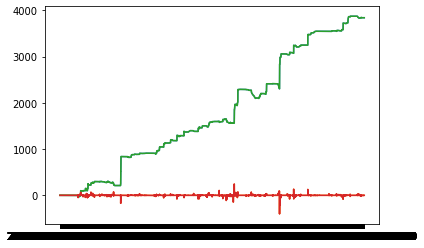

In [24]:
start = time.time()


# Test by trading continuously
[opt_action] = sess.run([RL_Train.output], feed_dict=RL_Train.feed_dict)
opt_action = np.argmax(opt_action)
action_dict = RL_Train.action_space.convert(opt_action, 'index_to_dict')
indices = range(601, len(EG_Test.x) - 1200)

pnl = pd.DataFrame()
pnl['Time'] = EG_Test.timestamp
pnl['Trade_Profit'] = 0
pnl['Cost'] = 0
pnl['N_Trade'] = 0


for i in indices:
    if i % 100 == 0:
        print(i)
    EG_Test.process(index=i, transaction_cost=0.001, **action_dict)
    trade_record = EG_Test.record
    if (trade_record is not None) and (len(trade_record) > 0):
        #print('value at {}'.format(i))
        trade_record = pd.DataFrame(trade_record)
        trade_cost   = trade_record.groupby('trade_time')['trade_cost'].sum()
        close_cost   = trade_record.groupby('close_time')['close_cost'].sum()
        profit       = trade_record.groupby('close_time')['profit'].sum()
        open_pos     = trade_record.groupby('trade_time')['long_short'].sum()
        close_pos    = trade_record.groupby('close_time')['long_short'].sum() * -1

        pnl['Cost'].loc[pnl['Time'].isin(trade_cost.index)] += trade_cost.values
        pnl['Cost'].loc[pnl['Time'].isin(close_cost.index)] += close_cost.values
        pnl['Trade_Profit'].loc[pnl['Time'].isin(close_cost.index)] += profit.values
        pnl['N_Trade'].loc[pnl['Time'].isin(trade_cost.index)] += open_pos.values
        pnl['N_Trade'].loc[pnl['Time'].isin(close_cost.index)] += close_pos.values

warnings.filterwarnings(action='once')

# Plot the testing result
pnl['PnL'] = (pnl['Trade_Profit'] - pnl['Cost']).cumsum()
plt.plot(pnl['PnL'])
plt.plot(pnl['N_Trade'])
plt.plot(pnl['Time'], pnl['PnL'])

plt.plot(pnl['Time'], pnl['N_Trade'])

sess.close()

print((time.time()-start)/60)